# Extreme Value Statistics of the halo and stellar mass distributions

In this notebook we show how to create confidence intervals in the stellar/halo mass--redshift plane for the most massive object predicted by extreme value statistics (EVS) of the halo mass function (HMF), combined with realistic models of the stellar and baryon fraction. In these examples we use pre-calculated arrays assuming the same fiducial cosmology and halo mass function parametrisation used in Lovell et al. 2022; detais on how to re-calculate these arrays for _e.g._ arbitrary cosmologies is described at the bottom of this notebook.

This notebook requires the following modules to be installed: `numpy`, `h5py`, `astropy` and `matplotlib`.

### An example

You first need to install the `evstats` module, which should be as simple as cloning this repository and running

`python setup.py install`

in the module parent directory.

We can then import our required modules.

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import astropy.units as u

from evstats import evs
from evstats.stats import compute_conf_ints, eddington_bias
from evstats.stellar import apply_fs_distribution

We then load pre-computed arrays, that we can apply a chosen sky fraction ($f_{\mathrm{sky}}$) to using `evs._apply_fsky`. Here we calculate the probability density function (PDF) of the halo mass function for a 90 arcmin$^2$ survey.

In [3]:
with h5py.File('data/evs_all.h5','r') as hf:
    log10m = hf['log10m'][:]
    f = hf['f'][:]
    F = hf['F'][:]
    N = hf['N'][:]
    z = hf['z'][:]
    

whole_sky = (41252.96 * u.deg**2).to(u.arcmin**2)
survey_area = 90 * u.arcmin**2
fsky = float(survey_area / whole_sky)
phi_max = evs._apply_fsky(N, f, F, fsky)

We can then compute the confidence intervals from this PDF with `compute_conf_ints` and plot:

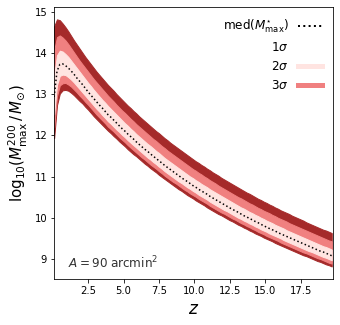

In [8]:
CI_mhalo = compute_conf_ints(phi_max, log10m)

colors = ['brown','lightcoral','mistyrose']

fig, ax = plt.subplots(1, 1, figsize=(5,5))

ax.fill_between(z, CI_mhalo[:,0], CI_mhalo[:,6], alpha=1, color=colors[0])
ax.fill_between(z, CI_mhalo[:,1], CI_mhalo[:,5], alpha=1, color=colors[1])
ax.fill_between(z, CI_mhalo[:,2], CI_mhalo[:,4], alpha=1, color=colors[2])
ax.plot(z, CI_mhalo[:,3], linestyle='dotted', c='black')

ax.set_xlim(0.1, 19.8);
ax.set_xlabel('$z$', size=17)
ax.set_ylabel('$\mathrm{log_{10}}(M^{200}_{\mathrm{max}} \,/\, M_{\odot})$', size=15)
ax.text(0.05, 0.04, '$A = 90 \; \mathrm{arcmin}^2$', size=12, color='black', alpha=0.8, transform = ax.transAxes)

line1 = plt.Line2D((0,1),(0,0), color=colors[0], linewidth=5)
line2 = plt.Line2D((0,1),(0,0), color=colors[1], linewidth=5)
line3 = plt.Line2D((0,1),(0,0), color=colors[2], linewidth=5)
line4 = plt.Line2D((0,1),(0,0), color='black', linestyle='dotted', linewidth=2)
line_dummy = plt.Line2D((0,1),(0,0), color='white')
leg = ax.legend(handles=[line4,line_dummy,line3,line2,line1], 
           labels=['$\mathrm{med}(M^{\star}_{\mathrm{max}})$',
               '$1\sigma$', '$2\sigma$', '$3\sigma$'],
                frameon=False, loc='upper right', fontsize=12, ncol=1)

vp = leg._legend_box._children[-1]._children[0] 
for c in vp._children: c._children.reverse() 
vp.align="right" 

If we wish to calculate the EVS PDF of the stellar mass distribution, we must choose values / distributions for the baryon and stellar fractions. Here we choose a fixed baryon fraction of $f_{\mathrm{b}} = 0.16$, and a log-normal distribution for the stellar fraction. 

The number of samples used to calculate the stellar fraction distribution is defined with `_N` - reducing this significantly speeds up the calculation, at the expense of reduced fidelity.

In [18]:
f_b = 0.16
CI_baryon = np.log10(10**CI_mhalo * f_b)

_N = int(1e4)
mstar_pdf = np.vstack([apply_fs_distribution(_phi_max, log10m, _N=_N, method='lognormal') \
        for _phi_max in phi_max])

We can then again compute the confidence intervals, and plot. We also plot the $3\sigma$ upper limits from assuming a stellar fraction of unity (black dashed line), as a conservative upper limit.

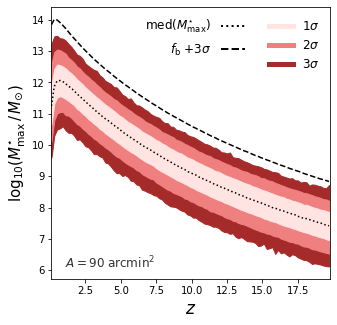

In [19]:
CIs = compute_conf_ints(mstar_pdf, log10m)

fig, ax = plt.subplots(1, 1, figsize=(5,5))

colors = ['brown','lightcoral','mistyrose']

ax.fill_between(z, CIs[:,0], CIs[:,6], alpha=1, color=colors[0])
ax.fill_between(z, CIs[:,1], CIs[:,5], alpha=1, color=colors[1])
ax.fill_between(z, CIs[:,2], CIs[:,4], alpha=1, color=colors[2])
ax.plot(z, CIs[:,3], linestyle='dotted', c='black')
ax.plot(z, CI_baryon[:,6], linestyle='dashed', color='black')

ax.set_xlim(0.1, 19.8); 
# ax.set_ylim(5.4, 11.8)
ax.set_xlabel('$z$', size=17)
ax.set_ylabel('$\mathrm{log_{10}}(M^{\star}_{\mathrm{max}} \,/\, M_{\odot})$', size=15)
ax.text(0.05, 0.04, '$A = 90 \; \mathrm{arcmin}^2$', size=12, color='black', alpha=0.8, transform = ax.transAxes)

line1 = plt.Line2D((0,1),(0,0), color=colors[0], linewidth=5)
line2 = plt.Line2D((0,1),(0,0), color=colors[1], linewidth=5)
line3 = plt.Line2D((0,1),(0,0), color=colors[2], linewidth=5)
line4 = plt.Line2D((0,1),(0,0), color='black', linestyle='dotted', linewidth=2)
line5 = plt.Line2D((0,1),(0,0), color='black', linestyle='dashed', linewidth=2)
line_dummy = plt.Line2D((0,1),(0,0), color='white')
leg = ax.legend(handles=[line4,line5,line_dummy,line3,line2,line1], 
           labels=['$\mathrm{med}(M^{\star}_{\mathrm{max}})$','$f_{\mathrm{b}}$ $+3\sigma$','',
               '$1\sigma$', '$2\sigma$', '$3\sigma$'],
                frameon=False, loc='upper right', fontsize=12, ncol=2)

vp = leg._legend_box._children[-1]._children[0] 
for c in vp._children: c._children.reverse() 
vp.align="right" 

### Using pre-calculated arrays of $f(m)$, $F(m)$ and $N$

In the example above we used pre-computed arrays for $f(m)$ and $F(m)$, with the sky fraction factored out. This allows arbitrary surveys areas to be calculated easily.

If you wish to explore the impact of changing the cosmology, or the chosen halo mass function parametrisation, these grids will need to be calculated again. A script for doing this is provided in `run_lightcone.py`. This can be called with an output filename as the first argument, and the necessary arrays will be saved to a HDF5 file. This can then be used as above. 